# 04 - Train Model

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


#notebook settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv(os.path.join('..','data','processed','data_for_model.csv'))

print(data.shape)

data.head()

(7389, 95)


,home_team,away_team,full_time_result,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_total_goals,away_roll_3_avg_home_total_goals,home_roll_3_avg_away_total_goals,away_roll_3_avg_away_total_goals,home_roll_3_avg_home_total_shots,away_roll_3_avg_home_total_shots,home_roll_3_avg_away_total_shots,away_roll_3_avg_away_total_shots,home_roll_3_avg_home_shots_on_target,away_roll_3_avg_home_shots_on_target,home_roll_3_avg_away_shots_on_target,away_roll_3_avg_away_shots_on_target,home_roll_3_avg_home_fouls,away_roll_3_avg_home_fouls,home_roll_3_avg_away_fouls,away_roll_3_avg_away_fouls,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_home_shot_accuracy,away_roll_3_avg_home_shot_accuracy,home_roll_3_avg_away_shot_accuracy,away_roll_3_avg_away_shot_accuracy,home_roll_3_avg_ratio_h_a_shots,away_roll_3_avg_ratio_h_a_shots,home_roll_3_avg_ratio_h_a_fouls,away_roll_3_avg_ratio_h_a_fouls,home_roll_3_avg_ratio_a_h_shots,away_roll_3_avg_ratio_a_h_shots,home_roll_3_avg_ratio_a_h_fouls,away_roll_3_avg_ratio_a_h_fouls,home_roll_3_avg_goal_difference,away_roll_3_avg_goal_difference,home_roll_5_avg_home_total_goals,away_roll_5_avg_home_total_goals,home_roll_5_avg_away_total_goals,away_roll_5_avg_away_total_goals,home_roll_5_avg_home_total_shots,away_roll_5_avg_home_total_shots,home_roll_5_avg_away_total_shots,away_roll_5_avg_away_total_shots,home_roll_5_avg_home_shots_on_target,away_roll_5_avg_home_shots_on_target,home_roll_5_avg_away_shots_on_target,away_roll_5_avg_away_shots_on_target,home_roll_5_avg_home_fouls,away_roll_5_avg_home_fouls,home_roll_5_avg_away_fouls,away_roll_5_avg_away_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_home_shot_accuracy,away_roll_5_avg_home_shot_accuracy,home_roll_5_avg_away_shot_accuracy,away_roll_5_avg_away_shot_accuracy,home_roll_5_avg_ratio_h_a_shots,away_roll_5_avg_ratio_h_a_shots,home_roll_5_avg_ratio_h_a_fouls,away_roll_5_avg_ratio_h_a_fouls,home_roll_5_avg_ratio_a_h_shots,away_roll_5_avg_ratio_a_h_shots,home_roll_5_avg_ratio_a_h_fouls,away_roll_5_avg_ratio_a_h_fouls,home_roll_5_avg_goal_difference,away_roll_5_avg_goal_difference,home_cumulative_points,away_cumulative_points
0,aston villa,bolton,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,everton,man united,A,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
2,fulham,birmingham,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [3]:
data.columns

Index(['home_team', 'away_team', 'full_time_result', 'day_of_week', 'month',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'home_roll_3_avg_home_total_goals', 'away_roll_3_avg_home_total_goals',
       'home_roll_3_avg_away_total_goals', 'away_roll_3_avg_away_total_goals',
       'home_roll_3_avg_home_total_shots', 'away_roll_3_avg_home_total_shots',
       'home_roll_3_avg_away_total_shots', 'away_roll_3_avg_away_total_shots',
       'home_roll_3_avg_home_shots_on_target',
       'away_roll_3_avg_home_shots_on_target',
       'home_roll_3_avg_away_shots_on_target',
       'away_roll_3_avg_away_shots_on_target', 'home_roll_3_avg_home_fouls',
       'away_roll_3_avg_home_fouls', 'home_roll_3_avg_away_fouls',
       'away_roll_3_avg_away_fouls', 'home_roll_3_avg_home_corners',
       'away_roll_3_avg_home_corners', 'home_roll_3_avg_away_corners',
       'away_roll_3_avg_away_corners', 'home_roll_3_avg_home_yellow_cards',
       'away_roll_3_avg_home_yellow

In [4]:
# define X and y
X = data.drop(columns=['full_time_result'])
y = data['full_time_result']

In [5]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5911, 94), (1478, 94), (5911,), (1478,))

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Preprocessing Function
def preprocess_data(X, y):
    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = list(X.drop(columns=categorical_features).columns)
    
    # Preprocess categorical and numerical features
    ct = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])
    X_processed = ct.fit_transform(X)
    
    # Encode target variable ('H', 'D', 'A')
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)  # Converts 'H', 'D', 'A' to 0, 1, 2
    y_categorical = to_categorical(y_encoded)  # One-hot encoding
    
    return X_processed, y_categorical, ct, label_encoder

# Preprocess the data
X_train_processed, y_train_processed, ct, label_encoder = preprocess_data(X_train, y_train)
X_test_processed = ct.transform(X_test)
y_test_encoded = label_encoder.transform(y_test)
y_test_processed = to_categorical(y_test_encoded)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))  # Convert to dict for Keras

# Build the model
model = Sequential([
    Input(shape=(X_train_processed.shape[1],)),  # Input layer
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Hidden layer 1 with L2 regularization
    Dropout(0.5),  # Increased dropout for stronger regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Hidden layer 2 with L2 regularization
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer with 3 classes (H, D, A)
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(X_train_processed, y_train_processed,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1,
                    class_weight=class_weights,
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_processed)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict probabilities
predictions = model.predict(X_test_processed)
y_pred = label_encoder.inverse_transform(np.argmax(predictions, axis=1))  # Convert predictions back to labels

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


2025-01-05 19:37:14.201323: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-05 19:37:14.441795: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-05 19:37:14.645112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736105834.817160    3222 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736105834.865780    3222 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 19:37:15.298599: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/100


W0000 00:00:1736105838.346849    3222 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3470 - loss: 3.2708 - val_accuracy: 0.4345 - val_loss: 2.2520 - learning_rate: 0.0010
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4278 - loss: 2.1163 - val_accuracy: 0.4615 - val_loss: 1.7574 - learning_rate: 0.0010
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4773 - loss: 1.6646 - val_accuracy: 0.4497 - val_loss: 1.4684 - learning_rate: 0.0010
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4982 - loss: 1.3962 - val_accuracy: 0.4827 - val_loss: 1.2816 - learning_rate: 0.0010
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5025 - loss: 1.2643 - val_accuracy: 0.5334 - val_loss: 1.1628 - learning_rate: 0.0010
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5497 - loss: 1.1338 - val_accuracy: 0.5156 - val_loss: 1.1106 - learning_rate: 0.0010
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5437 - loss: 1.0849 - val_a

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        23,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,859 (370.55 KB)

 Trainable params: 31,619 (123.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,240 (247.04 KB)

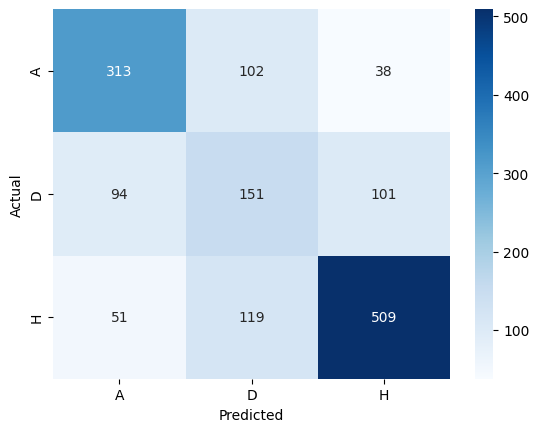

In [8]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

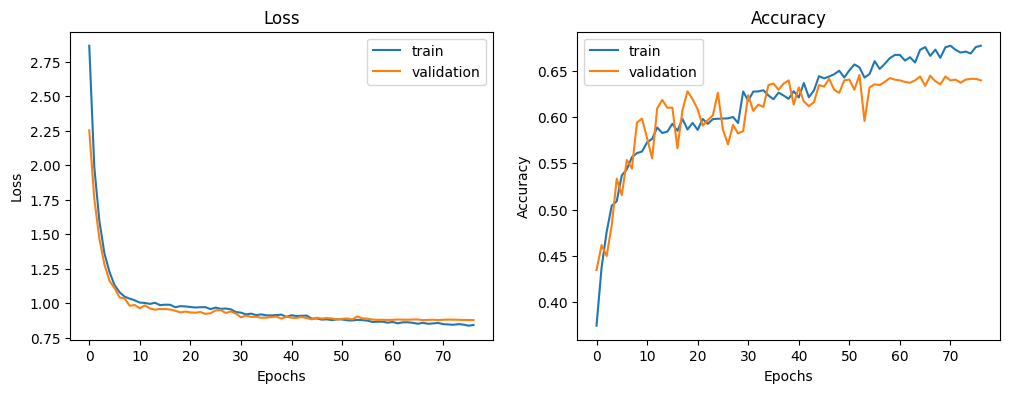

In [9]:
# plot the learning curves for loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

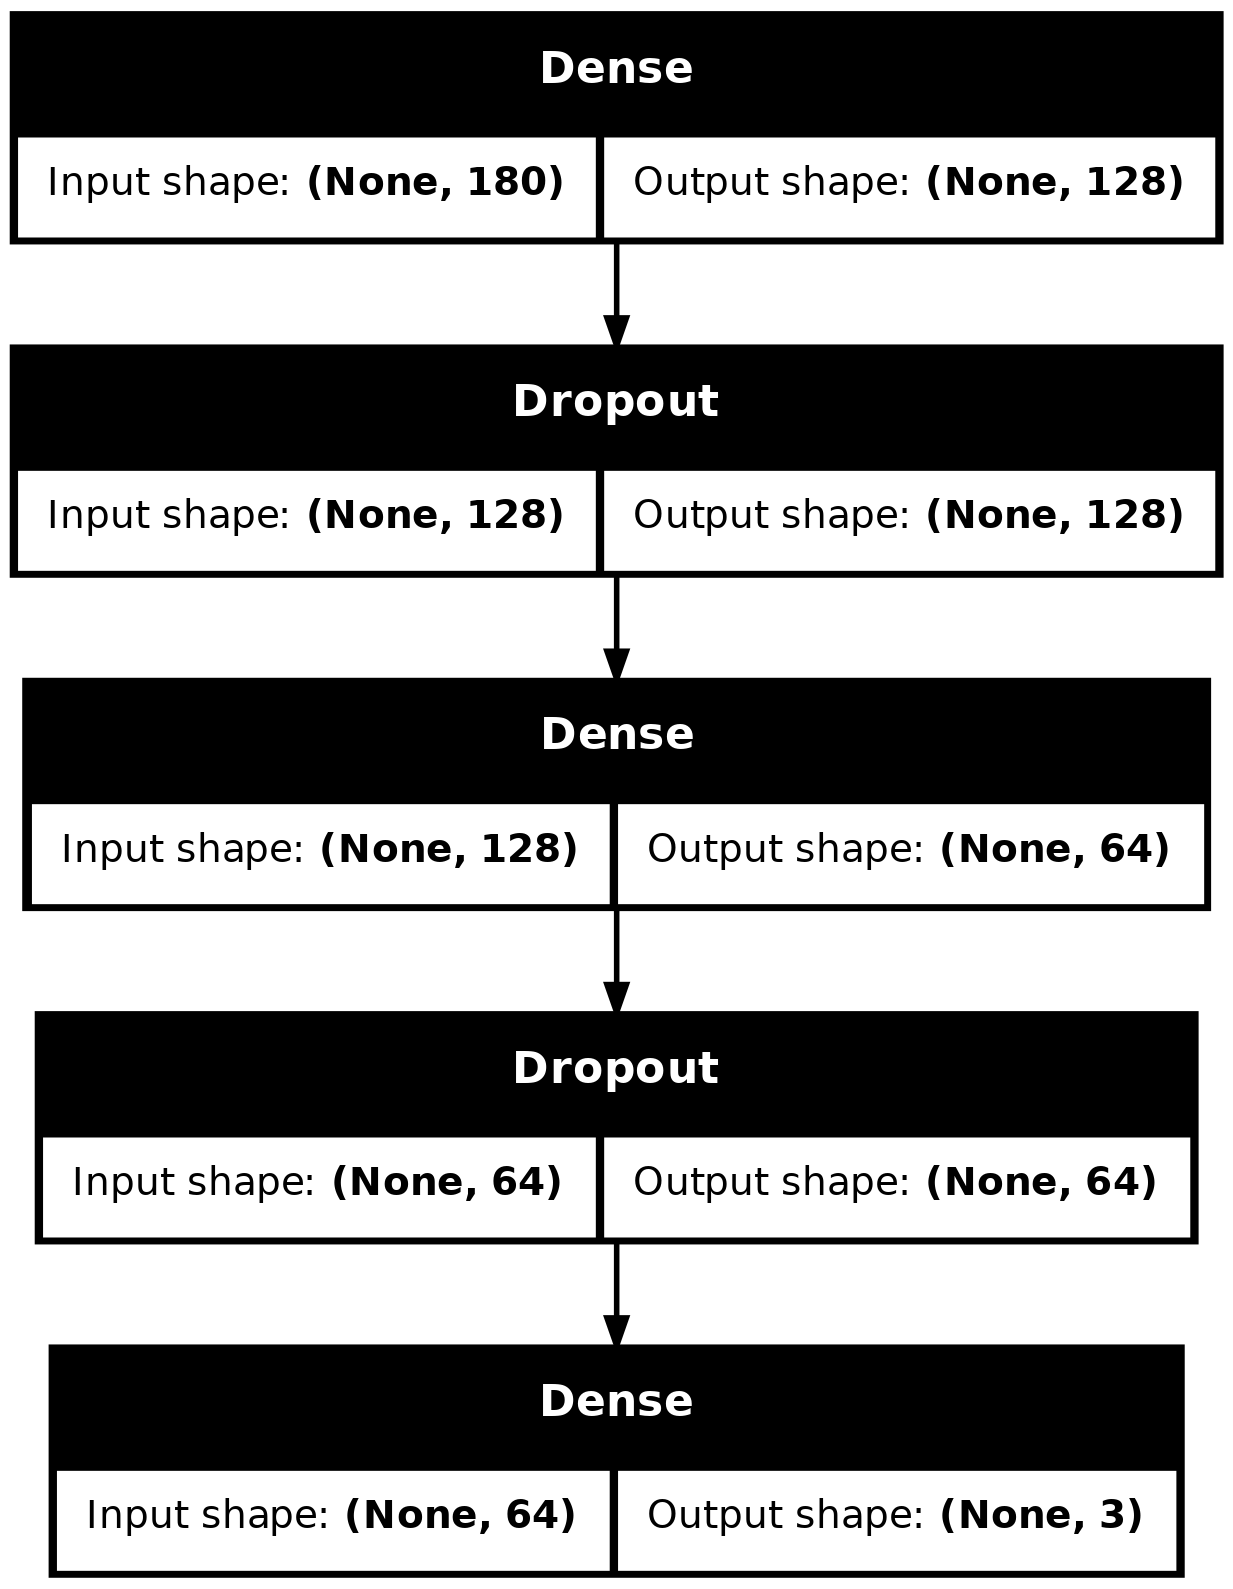

In [10]:
# visualize the neural network architecture
from tensorflow.keras.utils import plot_model

path_to_save = os.path.join('..','images','model_NN.png')

plot_model(model, show_shapes=True, show_layer_names=False, to_file=path_to_save)

In [11]:
# save the model
path_to_save_model = os.path.join('..','models','model_NN.keras')

model.save(path_to_save_model)

# how many MB the model is
os.path.getsize(path_to_save_model) / (1024 * 1024)  # in MB

0.3903980255126953

In [12]:
# load the model
from tensorflow.keras.models import load_model

model_loaded = load_model(path_to_save_model)

# Evaluate the loaded model
test_loss, test_accuracy = model_loaded.evaluate(X_test_processed, y_test_processed)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict probabilities
predictions = model_loaded.predict(X_test_processed)
y_pred = label_encoder.inverse_transform(np.argmax(predictions, axis=1))  # Convert predictions back to labels

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6686 - loss: 0.8595 
Test Accuracy: 0.66
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           A       0.68      0.69      0.69       453
           D       0.41      0.44      0.42       346
           H       0.79      0.75      0.77       679

    accuracy                           0.66      1478
   macro avg       0.62      0.63      0.62      1478
weighted avg       0.67      0.66      0.66      1478


Confusion Matrix:
[[313 102  38]
 [ 94 151 101]
 [ 51 119 509]]


In [13]:
import random

rand_point = random.randint(0, X_test.shape[0])

# make prediction for a random new point
new_point = X_test.iloc[rand_point]

print(new_point)

new_point_processed = ct.transform(new_point.to_frame().T)

prediction = model_loaded.predict(new_point_processed)

home_team_prob = prediction[0][0]
draw_prob = prediction[0][1]
away_team_prob = prediction[0][2]

name_home_team = new_point['home_team']
name_away_team = new_point['away_team']

print(f"Prediction for the match between {name_home_team} and {name_away_team}:")
print(f"Home team win probability: {home_team_prob:.2f}")
print(f"Draw probability: {draw_prob:.2f}")
print(f"Away team win probability: {away_team_prob:.2f}")


home_team                                   burnley
away_team                               aston villa
day_of_week                                       2
month                                             1
day_of_week_sin                            0.866025
day_of_week_cos                                -0.5
month_sin                                       0.5
month_cos                                  0.866025
home_roll_3_avg_home_total_goals           0.666667
away_roll_3_avg_home_total_goals           2.333333
home_roll_3_avg_away_total_goals                2.0
away_roll_3_avg_away_total_goals           0.333333
home_roll_3_avg_home_total_shots           6.333333
away_roll_3_avg_home_total_shots          17.333333
home_roll_3_avg_away_total_shots          13.333333
away_roll_3_avg_away_total_shots           9.333333
home_roll_3_avg_home_shots_on_target       2.333333
away_roll_3_avg_home_shots_on_target            6.0
home_roll_3_avg_away_shots_on_target       4.333333
away_roll_3_